# Denoising VSD signals of propagating waves in monkey visual cortex with Linear Model decomposition

The purpose of this notebook is to denoise raw VSD signals of neural activity in the monkey visual cortex using the methods developed by Reynaud et al. in https://doi.org/10.1016/j.neuroimage.2010.08.041, in order to analyse propagating waves in the data.

This procedure is based on Linear-Model (LM) decomposition of the signal. It requires a prior knowledge of the different sources of noise (for instance: heartbeat , respiration, illumination) and the shape of the response to denoise. It is a challenge since the methods were already designed for evoked responses in awake monkey, whereas here we want also to denoise spontaneous response, especially in anesthetised monkey.

PLAN :

1. Propagating waves in Bks-processed signal

2. Raw signal analysis 

3. Linear Model design

4. Analysis of the denoised signals (unwritten)

### Importation

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.colors as colors
import scipy.ndimage as img
import scipy.signal as signal
import scipy.stats as stat
import numpy as np
from sklearn.linear_model import LinearRegression 

check https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html for the last package

## Data loading

Data available are videos of spontaneous and evoked activity in the visual cortex of awake monkey, recorded with ultra fast camera (Fs=110Hz). Raw signals are provided and preprocessed ones (Bks method: zero-frame division, blank substraction and z-score of raw data).

In [2]:
raw_blank_path = r'/media/mathis/Data/Mathis/raw_blank_z210908.npy' #change it to adapt to your directories
raw_evoked_path = r'/media/mathis/Data/Mathis/raw_pos4_z210908.npy'

bks_blank_path = r'/media/mathis/Data/Mathis/blank_ziggy_210908.npy'
bks_evoked_path = r'/media/mathis/Data/Mathis/gaussian_pos4_ziggy_210908.npy'

awak_pattern_path = r'/media/mathis/Data/Mathis/awake_annoted.png'


In [3]:
Raw_blank = np.load(raw_blank_path)
Raw_evoked = np.load(raw_evoked_path)

Bks_blank = np.load(bks_blank_path)
Bks_evoked = np.load(bks_evoked_path)

Vasc_pattern = plt.imread(awak_pattern_path)

## 1 : What do we want to denoise? Visualisation of travelling waves on Bks-processed trials

### 1.0 : intro

Here is a little introduction about **travelling waves**, the phenomenon we want to analyse in depth. I used a dataset generated after the "**Bks**" denoising procedure, i.e. another type of denoising method very easy to conduct, but also not very efficient. It's based on the "**zero-frame division**", which is the normalisation of the fluorescence activity by dividing pixel values over the mean fluorescence value on the first frames (=zero-frames). Then, the data are substracted with the 'blanks' (="**blank substraction**"), another recording of activity with the same dimension. Finally, data are z-scored. 

Reynaud et al. showed that this technique is easy but very noise-sensitive. So we'll just use this dataset in this section to understand better the type of signal we have, and then we'll try to denoise the raw data with Linear Model decomposition.

In [4]:
N_trials, Nt, Nx, Ny = Bks_evoked.shape

There is a 'dead pixel' in the Bks dataset, so we need to mask its values before plotting the histogram

In [5]:
Bks_blank_masked = Bks_blank[~np.isnan(Bks_blank)]
Bks_evoked_masked = Bks_evoked[~np.isnan(Bks_evoked)]

In [6]:
histo_blank, edges = np.histogram(Bks_blank_masked, bins=200, density=True)
histo_evoked, _ = np.histogram(Bks_evoked_masked, bins=200, density=True)

Fit=stat.norm.pdf(edges[:-1])

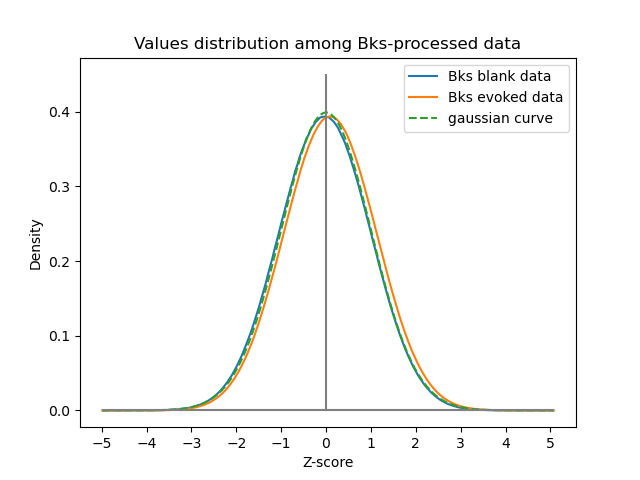

In [7]:
plt.figure()
plt.title('Values distribution among Bks-processed data')
plt.xlabel('Z-score')
plt.ylabel('Density')
plt.plot(edges[:-1],histo_blank,label='Bks blank data')
plt.plot(edges[:-1],histo_evoked,label='Bks evoked data')
plt.plot(edges[:-1],Fit,label='gaussian curve', linestyle='dashed')
plt.hlines(0, edges[0], edges[-2], 'gray')
plt.vlines(0,0,.45,'gray')
plt.xticks(range(-5,6))
plt.legend()
plt.show()

We can observe after a quick focus near the top of the curves that data are close to a normal distribution, but that the evoked set is a bit shifted to the positive values, contrary to the blank set.

To analyse a beautiful evoked wave, we will take the **trial n°8** in the Bks-processed/evoked/awake dataset.

In [8]:
n_trial = 8
Sample = np.copy(Bks_evoked[n_trial])

As the dataset is very noisy, a smoothing is required for visualisation.

### 1.1 : Smoothing the data to see the wave

#### Temporal filtering (Butterworth filter : lowpass under 20Hz)

In [9]:
butt_filt = signal.butter(N=4, Wn=[20], btype='lowpass', fs=110, output='sos')
Sample=signal.sosfiltfilt(butt_filt, Sample, axis=0)

#### Spatial smoothing (Gaussian filter)

In [10]:
mean = np.nanmean(Sample)
nan_mask = np.isnan(Sample)
Sample[nan_mask]=mean
Smooth  = np.zeros_like(Sample)
for n in range(Nt):
    Smooth[n]=img.gaussian_filter(Sample[n], sigma=5, mode='constant', cval=mean)
Sample=Smooth
Sample[nan_mask]=np.nan

#### Z-score of the data

In [11]:
mean = np.nanmean(Sample)
std = np.nanstd(Sample)
Sample=(Sample-mean)/std

### 1.2 : Visualisation of the wave

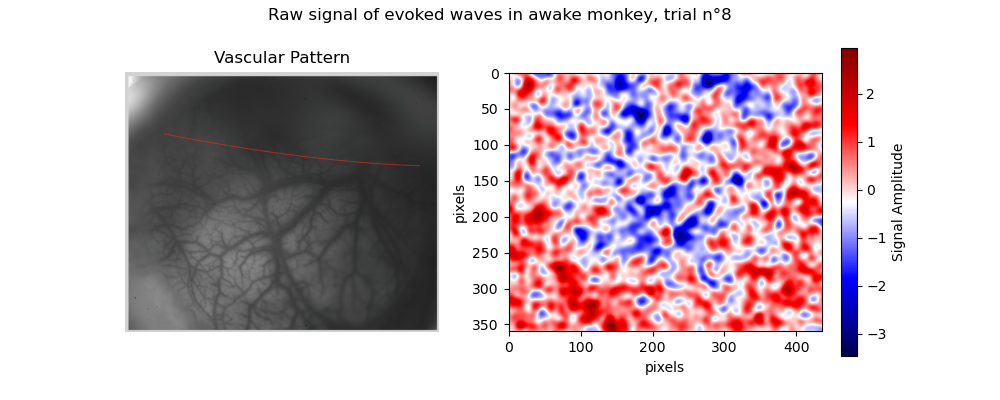

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4), width_ratios=[0.80,1])
fig.suptitle('Raw signal of evoked waves in awake monkey, trial n°'+str(n_trial))

vasculature = ax1.imshow(Vasc_pattern, cmap='gray', aspect='equal')

vsd_signal = ax2.imshow(Sample[0], cmap='seismic', aspect='equal')

cbar = fig.colorbar(vsd_signal, ax=ax2, label='Signal Amplitude')

ax1.set_title('Vascular Pattern')
ax1.axis('off')

ax2.set_xlabel('pixels')
ax2.set_ylabel('pixels')

def update(frame):
    vsd_signal.set_array(Sample[frame])
    ax2.set_title('frame n°'+str(frame))
    return [vsd_signal]

ani = anim.FuncAnimation(fig,func=update,frames=range(Nt),interval=100,repeat=False)
plt.show()

We can observe a noisy travelling wave from frames 23 to 40. Let's put a mask to remove the border to see more clearly the wave. 

### 1.3 : Masking the border

As the recording aperture is circular, we can use a circular mask, defining the *border* (out of the circle) and the *center* (in the circle)

In [13]:
def circular_mask(shape, center, radius):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    return ((X - center[0]) ** 2 + (Y - center[1]) ** 2) <= radius ** 2

In [14]:
image_mask = circular_mask(Sample.shape[1:], center=(220,190), radius=175)

N_center = np.sum(image_mask)
N_border = np.sum(~image_mask)

film_mask = np.array([image_mask for _ in range(Nt)])
                      
masked_sample = np.copy(Sample)
masked_sample[~film_mask]=np.nan

center_series = np.transpose(Sample[:,image_mask])

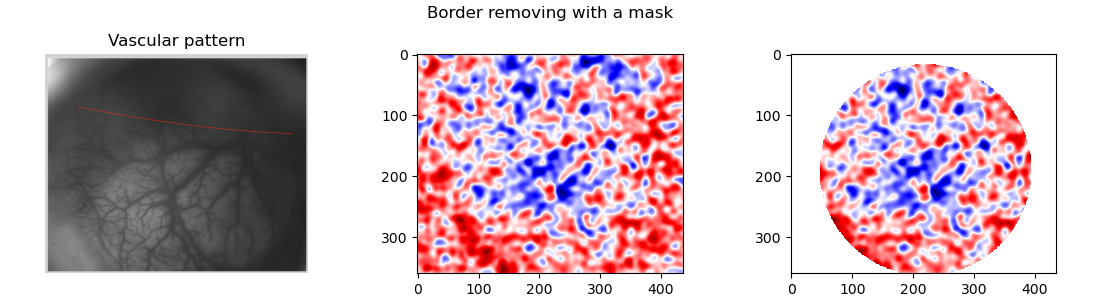

In [15]:
fig, axs = plt.subplots(1,3, tight_layout=True, figsize=(11,3))
fig.suptitle('Border removing with a mask')

axs[0].set_title("Vascular pattern")
axs[0].imshow(Vasc_pattern, cmap='gray', aspect='equal')
axs[0].axis('off')

unmasked = axs[1].imshow(Sample[0], cmap='seismic', aspect='equal')

masked = axs[2].imshow(masked_sample[0], cmap='seismic', aspect='equal')


def update(frame):
    unmasked.set_array(Sample[frame])
    masked.set_array(masked_sample[frame])
    axs[1].set_title('frame n°'+str(frame))
    axs[2].set_title('frame n°'+str(frame))
    return [unmasked, masked]

ani = anim.FuncAnimation(fig,func=update,frames=range(Nt),interval=100,repeat=False)
plt.show()

### 1.4 : Time series of the Bks-processed signals

Plot time series of randomly-picked pixels within the center

#### Random picking

In [16]:
n_picks = 1000

Picked_indices = np.sort(np.random.choice(N_center, n_picks))

Series = center_series[Picked_indices, :]

#### Temporal and total (spatial and temporal) averages of the time series

In [17]:
mu_tot, std_tot = np.nanmean(Series),np.nanstd(Series)
mu, std =np.nanmean(Series, axis=0), np.nanstd(Series, axis=0)

#### Finding pixels implied in the wave with a threshold

In [18]:
Wave_indices = np.max(Series, axis=1)>mu_tot+2.5*std_tot

#### Time series plots

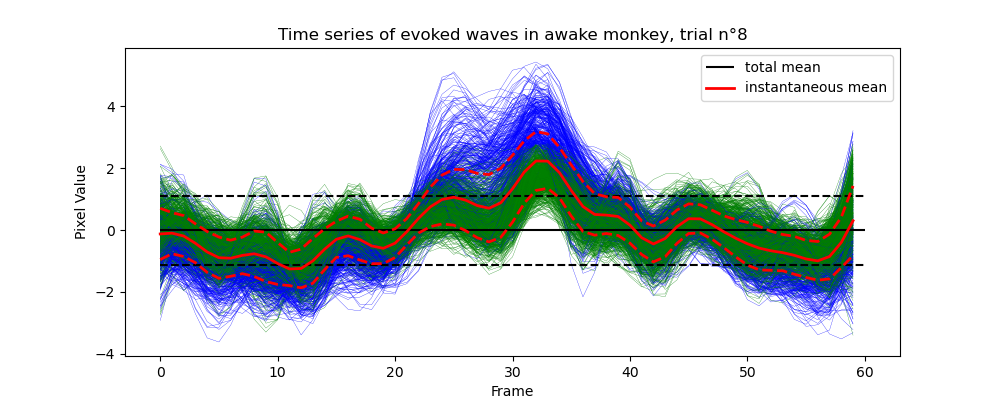

In [19]:
plt.figure(figsize=(10,4))
plt.title('Time series of evoked waves in awake monkey, trial n°'+str(n_trial))

plt.xlabel('Frame')
plt.ylabel('Pixel Value')

for i in range(n_picks):
    if Wave_indices[i]:
        plt.plot(Series[i,:], linewidth=.2, color='blue')
    else:
        plt.plot(Series[i,:], linewidth=.2, color='green')

plt.hlines(mu_tot, 0, Nt, 'k', linestyles='solid', label='total mean')
plt.hlines(mu_tot+std_tot, 0, Nt, 'k', linestyles='dashed')
plt.hlines(mu_tot-std_tot, 0, Nt, 'k', linestyles='dashed')

plt.plot(mu, 'red', linewidth=2, label='instantaneous mean')
plt.plot(mu+std, 'red', linewidth=2, linestyle='dashed')
plt.plot(mu-std, 'red', linewidth=2, linestyle='dashed')

plt.legend()
plt.show()

### 1.5 : Power spectra of the time series

In [20]:
fs=110 #Hz
freqs = np.fft.fftfreq(Nt, d=1/fs)
f = freqs[1:Nt//2-1]

ft = np.fft.fft(Series, axis=1)

ps = np.abs(ft)**2

mean_ps = np.mean(ps, axis=0)
ps_mean = np.abs(np.fft.fft(mu))**2

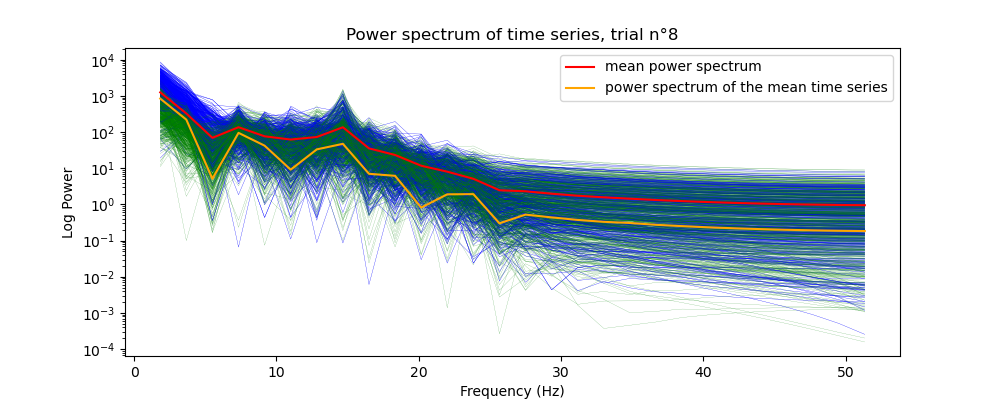

In [21]:
plt.figure(figsize=(10,4))
plt.title('Power spectrum of time series, trial n°'+str(n_trial))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Power')
plt.yscale('log')


for i in range(n_picks):
    if Wave_indices[i]:
        plt.plot(f, ps[i,1:Nt//2-1], linewidth=.2, color='blue')
    else:
        plt.plot(f, ps[i,1:Nt//2-1], linewidth=.1, color='green')
        
plt.plot(f, mean_ps[1:Nt//2-1],color='red', label='mean power spectrum')
plt.plot(f, ps_mean[1:Nt//2-1],color='orange', label='power spectrum of the mean time series')

plt.legend()
plt.show()

## 2 : Raw signal analysis

After this quick glaze upon processed data, we have to start from scratch with raw signals.

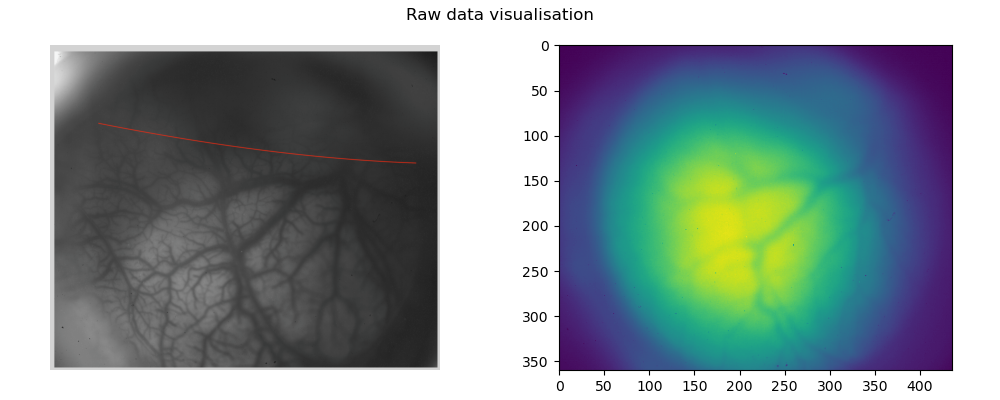

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.suptitle('Raw data visualisation')
ax1.imshow(Vasc_pattern, cmap='gray')
ax1.axis('off')
ax2.imshow(Raw_blank[0,0])
plt.tight_layout()
plt.show()

So as you can see, raw data presents a clear visible vascular pattern, which is eliminated during the Blank-substraction step in Bks-proccessed data.

### Raw signals values range

In [23]:
histo_raw_blank, edges = np.histogram(Raw_blank, bins=200, density=True)
histo_raw_evoked, _ = np.histogram(Raw_evoked, bins=200, density=True)

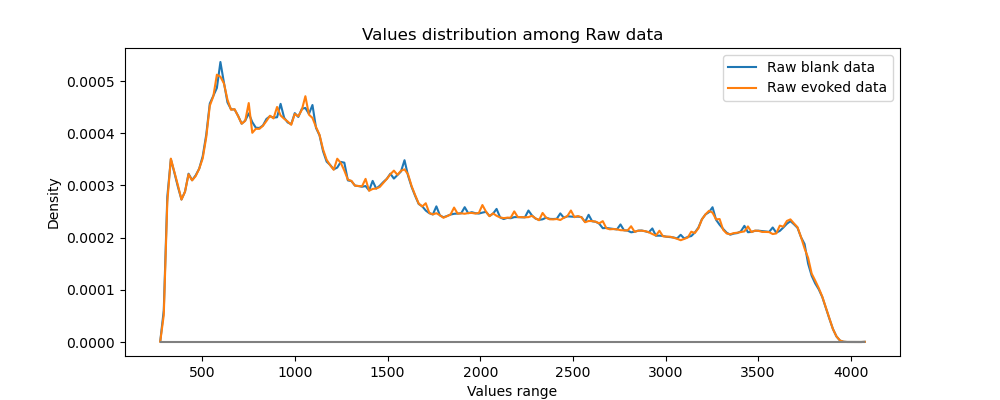

In [24]:
plt.figure(figsize=(10,4))
plt.title('Values distribution among Raw data')
plt.xlabel('Values range')
plt.ylabel('Density')
plt.plot(edges[:-1],histo_raw_blank,label='Raw blank data')
plt.plot(edges[:-1],histo_raw_evoked,label='Raw evoked data')
plt.hlines(0, edges[0], edges[-2], 'gray')
plt.legend()
plt.show()

### What happens to a single pixel implied in a propagative wave?

Pixel coordinates

In [25]:
i,j = 240, 170

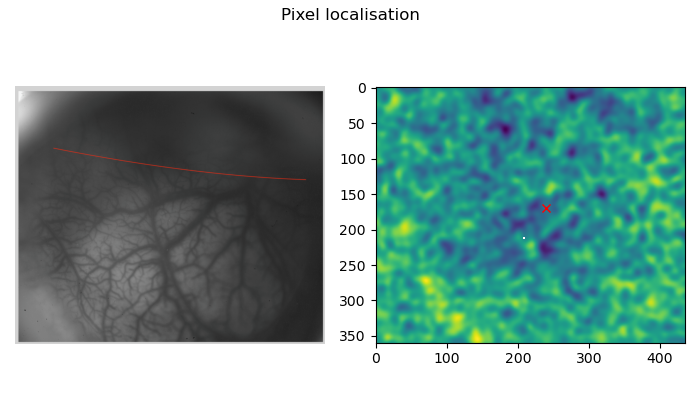

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(7,4))
fig.suptitle('Pixel localisation')
ax1.imshow(Vasc_pattern, cmap='gray')
ax1.axis('off')
ax2.imshow(Sample[0])
ax2.plot(i,j,'rx')
plt.tight_layout()
plt.show()

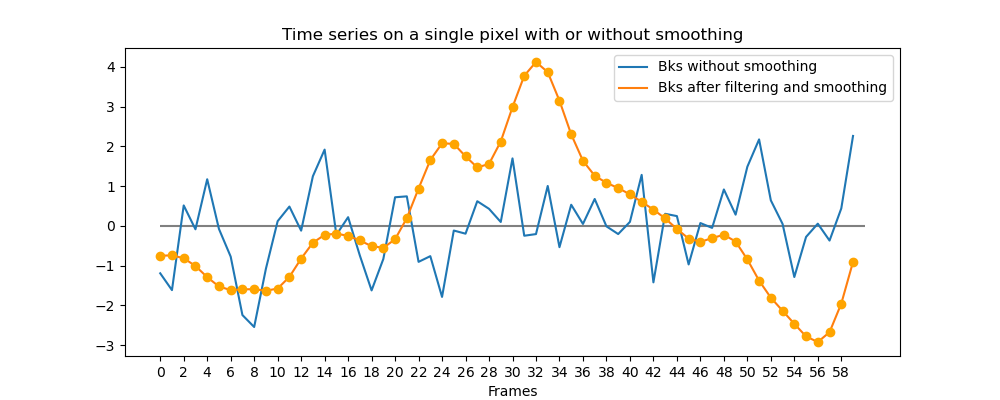

In [27]:
plt.figure(figsize=(10,4))
plt.title('Time series on a single pixel with or without smoothing')
plt.hlines(0,0,Nt, 'gray')
plt.xlabel('Frames')
plt.plot(Bks_evoked[n_trial,:,i,j], label='Bks without smoothing')
plt.plot(Sample[:,i,j], label='Bks after filtering and smoothing')
plt.plot(Sample[:,i,j], 'o', color='orange')
plt.xticks(range(0,Nt,2))
plt.legend()
plt.show()

What does the Bks method changed on this pixel ?

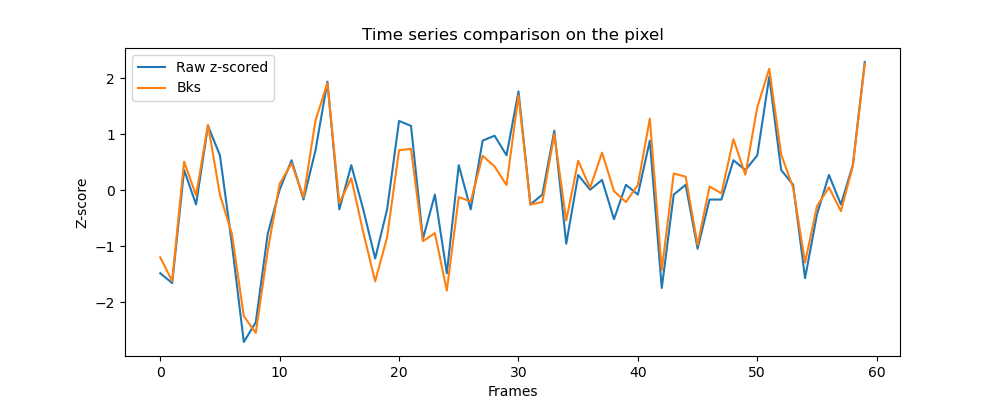

In [28]:
plt.figure(figsize=(10,4))
plt.title('Time series comparison on the pixel')
plt.xlabel('Frames')
plt.ylabel('Z-score')
plt.plot((Raw_evoked[n_trial,:,i,j]-np.mean(Raw_evoked[n_trial,:,i,j]))/np.std(Raw_evoked[n_trial,:,i,j]), label='Raw z-scored')
plt.plot(Bks_evoked[n_trial,:,i,j], label='Bks')
plt.legend()
plt.show()

Almost nothing is removed just with a blank-substraction... This is why we need to implement a more efficient denoising method.

## 3 : Building up the Linear Model

### 3.0 : Definition of the terms

Under the assumption of the General Linear Model, we can establish the following equation:

$ Y \space = X \beta + r = X_{noise} \space \beta_{noise} + X_{signal} \space \beta_{signal} + r$

With $Y$ the dataset to denoise, $X$ the regressor matrix, $\beta$ the vector containing the weights of each regressor and $r$ the residuals

We can then obtain the denoised signal $\frac{\Delta F}{F}$ :

$ \frac{\Delta F}{F} = \frac{1}{\beta_0} \cdot \left( Y - X_{noise} \space \beta_{noise} \right)$

With $\beta_0$ the coefficent associated with the constant baseline noise.

### 3.1 : General design

In [29]:
fs=110 #Hz
Time = np.array([n*1000/fs for n in range(Nt)]) #milliseconds
Time_sec = np.array([n/fs for n in range(Nt)]) #seconds
time_step = 9.09 #ms (approx 1/fs in ms)
Frames = np.array(range(Nt))

#### Noise sources

##### Oscillatory Noises

In [30]:
def oscillatory_components(fh, time_range):
    return np.array([np.cos(2*np.pi*fh*time_range), np.sin(2*np.pi*fh*time_range)])

In [31]:
#heartbeat -> 2 harmonics
cos2_5, sin2_5  = oscillatory_components(2.5, Time_sec)
cos5, sin5  = oscillatory_components(5, Time_sec)

#camera/illumination -> 5 harmonics
cos10, sin10  = oscillatory_components(10, Time_sec)
cos20, sin20  = oscillatory_components(20, Time_sec)
cos30, sin30  = oscillatory_components(30, Time_sec)
cos40, sin40  = oscillatory_components(40, Time_sec)
cos50, sin50  = oscillatory_components(50, Time_sec)

#unknown -> 2 frequencies
cos3_5, sin3_5  = oscillatory_components(3.5, Time_sec)
cos12, sin12  = oscillatory_components(12, Time_sec)

In [32]:
X1 = np.array([cos2_5, sin2_5, cos5, sin5,
cos10, sin10, cos20, sin20, cos30, sin30, cos40, sin40, cos50, sin50, 
cos3_5, sin3_5, 
cos12, sin12])

##### Bleaching noise

In [33]:
tau = 950 #ms
bleaching = np.exp(-Time/tau)-1

In [34]:
X2 = np.array([bleaching])

##### **Conclusion** : construction of the noise regressors matrix  $X_{noise}$

In [35]:
X_noise = np.append(X1, X2, axis=0)

#### Response model design

In [36]:
def generate_shape(alpha):
    cum_sum=np.cumsum(alpha)
    r_alpha=np.zeros(Nt)
    r_alpha[Frames>cum_sum[0]] = .5*(1-np.cos(np.pi*(Frames[Frames>cum_sum[0]]-cum_sum[0])/alpha[1]))
    r_alpha[Frames>cum_sum[1]] = 1
    r_alpha[Frames>cum_sum[2]] = .5*(1+np.cos(np.pi*(Frames[Frames>cum_sum[2]]-cum_sum[2])/alpha[3]))
    r_alpha[Frames>cum_sum[3]] = 0
    return r_alpha

Plot a shape example

In [37]:
alpha_example = [20,7,8,15]
shape_example = generate_shape(alpha_example)

Text(0.5, 0, 'Frames')

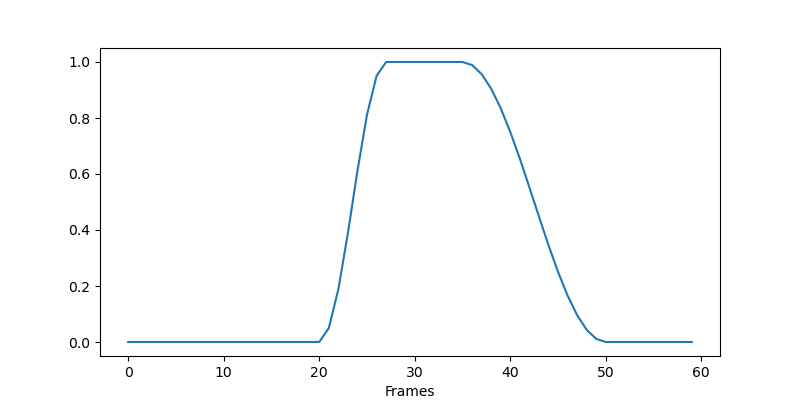

In [38]:
plt.figure(figsize=(8,4))
plt.plot(shape_example)
plt.xlabel('Frames')

Generating a set with all the posible shapes compatible with a stimulus starting at +100ms

In [39]:
print(time_step)

9.09


Here we have to propose values range for each parameter, expressed as integers (frame number), considering that the stimulus is presented after 100ms, which corresponds to the frame 11. So, the response couldn't appear before frame 18 minimum. Based on the time series, the sets below are proposed.

In [40]:
set_latency = np.arange(18,25)
set_raising = np.arange(2,10)
set_plateau = np.arange(5,12)
set_decaying= np.arange(5,20)

In [41]:
N_combination = set_latency.size*set_raising.size*set_plateau.size*set_decaying.size
print(N_combination)

5880


From this huge set of parameters, the corresponding shapes are generated.

In [42]:
alpha_mat=np.zeros((N_combination, 4))
r_mat = np.zeros((N_combination, Nt))
compt=0
for a1 in set_latency:
    for a2 in set_raising:
        for a3 in set_plateau:
            for a4 in set_decaying:
                alpha_mat[compt]=np.array([a1,a2,a3,a4])
                r_mat[compt]=generate_shape(alpha_mat[compt])
                compt+=1
r_alpha = np.transpose(r_mat)

Singular Value Decomposition (SVD) to reduce dimensionality of the set of shapes

In [43]:
U, S, Vh = np.linalg.svd(r_alpha,full_matrices=False)

Number of regressors to take (=$L$)

In [44]:
L=10

Proportion of shape variance explained by the $L$ first regressors : 

In [45]:
print(str(np.round(sum(S[:L])/sum(S)*100,2))+'%')

94.96%


Plot the $L$ regressors chosen

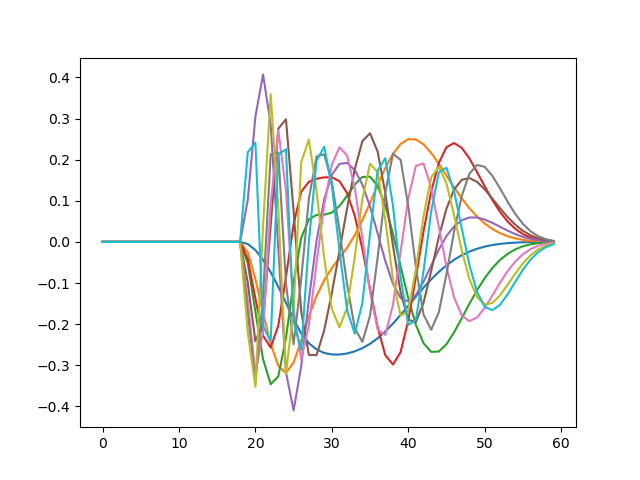

In [46]:
plt.figure()
plt.plot(U[:,:L])

Matrix of the response regressors $X_3$

In [47]:
X3=U[:,:L].T

##### **Conclusion** : construction of regressors matrix   $X = [X_1 \space X_2 \space X_3]$

In [48]:
X = np.append(X_noise, X3, axis=0).T

### 3.2  : Test LM denoising on the previous pixel

In [49]:
Y = Raw_evoked[n_trial, :, i,j]
reg = LinearRegression().fit(X,Y)

#### Quality of the regression

##### Reconstruction of the signal

In [50]:
pred = reg.predict(X)

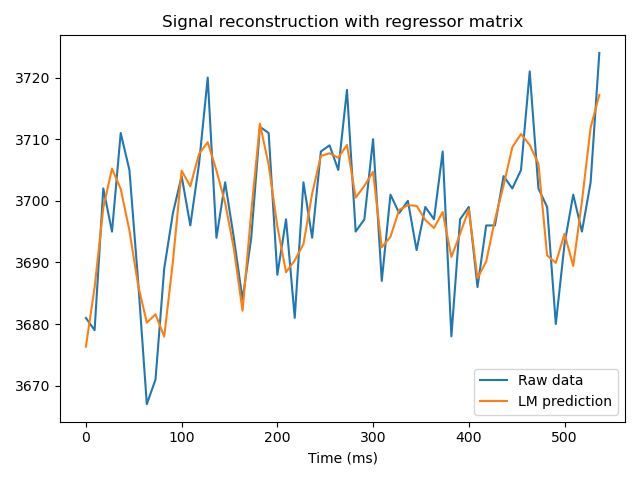

In [51]:
plt.figure(tight_layout=True)
plt.xlabel('Time (ms)')
plt.title('Signal reconstruction with regressor matrix')
plt.plot(Time,Y, label='Raw data')
plt.plot(Time, pred, label='LM prediction')
plt.legend()

##### $R^2$ of the fit:

In [52]:
print(str(round(reg.score(X,Y)*100, 2))+'%')

63.54%


Statistical analysis of the whole model

In [53]:
F_test = stat.f_oneway(pred, Y)
print(F_test)

F_onewayResult(statistic=1.0773769889793859e-26, pvalue=1.0)


#### Analysis of residuals 

In [54]:
residuals = Y-pred
µ_res, std_res = np.mean(residuals), np.std(residuals)

##### Time series

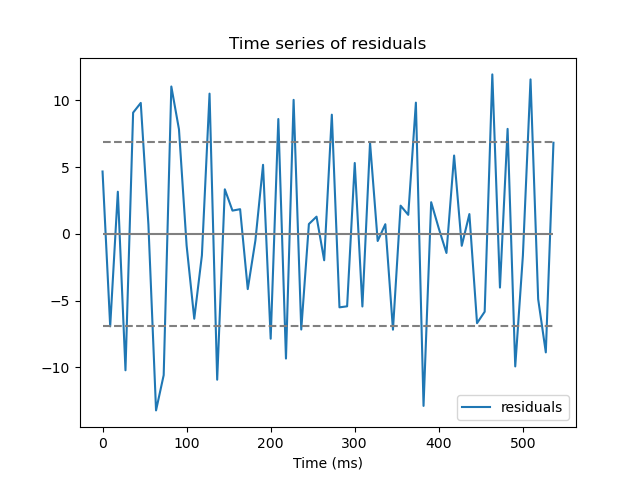

In [55]:
plt.figure()
plt.title('Time series of residuals')
plt.xlabel('Time (ms)')
plt.plot(Time, residuals, label='residuals')
plt.hlines(µ_res, Time[0], Time[-1], 'gray')
plt.hlines(µ_res+std_res, Time[0], Time[-1], 'gray', linestyle='dashed')
plt.hlines(µ_res-std_res, Time[0], Time[-1], 'gray', linestyle='dashed')
plt.legend()

##### Power spectrum

In [56]:
ft_res = np.fft.fft(residuals)
ps_res = np.abs(ft_res)**2

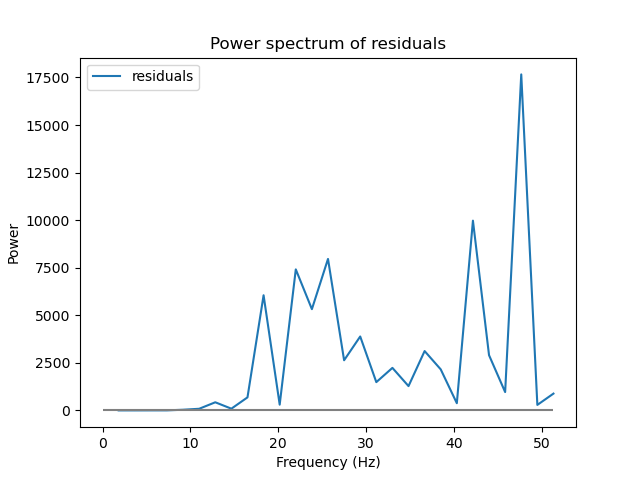

In [57]:
plt.figure()
plt.title('Power spectrum of residuals')
plt.plot(f,ps_res[1:Nt//2-1], label='residuals')
plt.hlines(0,0,f[-1],'gray')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()

Histogram of residual values

(array([ 6.,  8.,  7., 12., 10.,  7., 10.]),
 array([-13.22651814,  -9.63112758,  -6.03573703,  -2.44034648,
          1.15504408,   4.75043463,   8.34582518,  11.94121574]),
 <BarContainer object of 7 artists>)

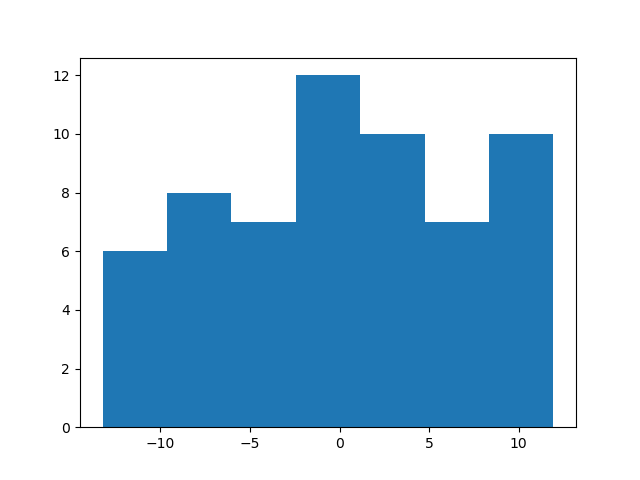

In [58]:
plt.figure()
plt.hist(residuals, bins='auto')

Kolmogorov-Smirnov test

In [59]:
KS_test=stat.kstest(residuals, "norm")
print(KS_test)

KstestResult(statistic=0.3589009645465979, pvalue=1.9964975507242997e-07, statistic_location=1.7380723234191464, statistic_sign=-1)


#### Denoising the signal

In [60]:
noise = X_noise.T@reg.coef_[:-L]+reg.intercept_

In [61]:
dF_F = (Y-noise)/reg.intercept_
zscore_dF_F = (dF_F-np.mean(dF_F))/np.std(dF_F)

In [62]:
zscore_raw = (Raw_evoked[n_trial,:,i,j]-np.mean(Raw_evoked[n_trial,:,i,j]))/np.std(Raw_evoked[n_trial,:,i,j])

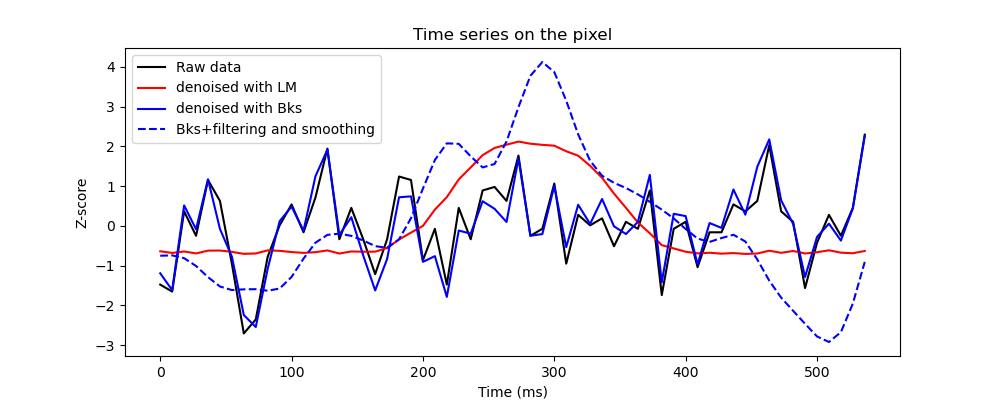

In [63]:
plt.figure(figsize=(10,4))
plt.title('Time series on the pixel')
plt.plot(Time,zscore_raw, label='Raw data', color='k')
plt.plot(Time,zscore_dF_F, label='denoised with LM', color='r')
plt.plot(Time, Bks_evoked[n_trial,:,i,j], label='denoised with Bks', color='b')
plt.plot(Time, Sample[:, i,j], label='Bks+filtering and smoothing', color='b', linestyle='dashed')
plt.xlabel('Time (ms)')
plt.ylabel('Z-score')
plt.legend()
plt.show()

In [64]:
response = noise = X3.T@reg.coef_[-L:]

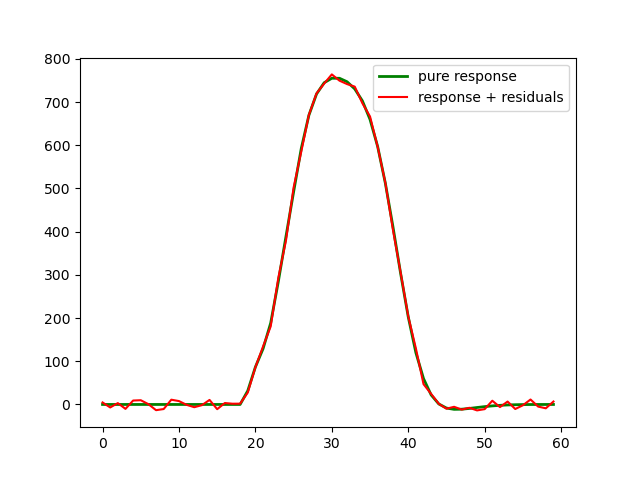

In [65]:
plt.figure()
plt.plot(response, label='pure response', color='green', linewidth=2)
plt.plot(response+residuals, label='response + residuals', color='r')
plt.legend()

### 3.3 : Test LM on the whole trial

In [66]:
Trial = np.copy(Raw_evoked[n_trial])
Trial[~film_mask]=np.nan

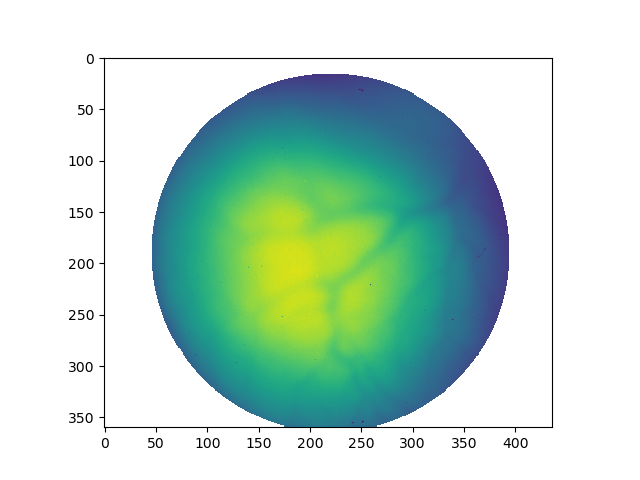

In [67]:
plt.figure()
plt.imshow(Trial[0])

Denoising loop over the pixels within the mask (it takes 2 minutes to compute)

In [68]:
Trial_denoised = np.zeros_like(Trial)
Score=[]
for indx in range(Nx):
    for indy in range(Ny):
        if np.isnan(Trial[0,indx,indy]):
            Trial_denoised[:,indx,indy] = np.nan
        else:
            Y_pix=Trial[:,indx,indy]
            reg_pix = LinearRegression().fit(X,Y_pix)
            Score.append(reg_pix.score(X,Y_pix))
            noise_pix = X_noise.T@reg_pix.coef_[:-L]
            Trial_denoised[:,indx,indy] = (Y_pix-noise_pix)/reg_pix.intercept_
Score=np.array(Score)

In [69]:
print(Score.mean())

0.5042771072850057


Time series of the mean value in the center

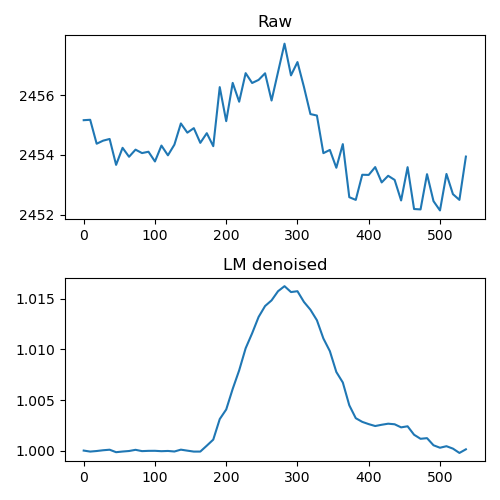

In [70]:
ts = np.nanmean(Trial, axis=(1,2))
ts_denoised = np.nanmean(Trial_denoised, axis=(1,2))

fig, (ax1,ax2)=plt.subplots(2,1, figsize=(5,5), tight_layout=True)
ax1.set_title('Raw')
ax1.plot(Time, ts)
ax2.set_title('LM denoised')
ax2.plot(Time, ts_denoised)

Z-score to facilitate the visualisation

In [71]:
mu_trial, std_trial = np.nanmean(Trial_denoised), np.nanstd(Trial_denoised)
Trial_denoised = (Trial_denoised-mu_trial)/std_trial

/tmp/ipykernel_25118/683757341.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4), width_ratios=[0.80,1])


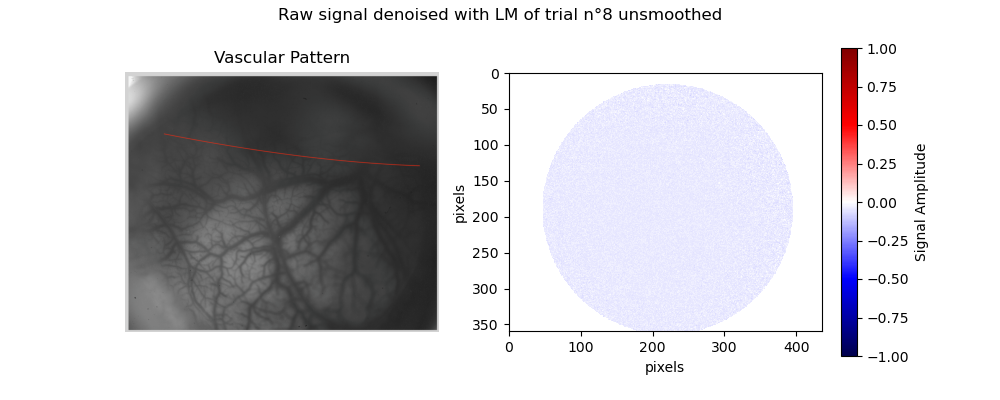

In [72]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4), width_ratios=[0.80,1])
fig.suptitle('Raw signal denoised with LM of trial n°8 unsmoothed')

vasculature = ax1.imshow(Vasc_pattern, cmap='gray', aspect='equal')

vsd_signal = ax2.imshow(Trial_denoised[0], cmap='seismic', aspect='equal', vmin=-1, vmax=1)

cbar = fig.colorbar(vsd_signal, ax=ax2, label='Signal Amplitude')

ax1.set_title('Vascular Pattern')
ax1.axis('off')

ax2.set_xlabel('pixels')
ax2.set_ylabel('pixels')

def update(frame):
    vsd_signal.set_array(Trial_denoised[frame])
    ax2.set_title('frame n°'+str(frame))
    return [vsd_signal]

ani = anim.FuncAnimation(fig,func=update,frames=range(Nt),interval=100,repeat=False)
plt.show()

Temporal filtering

In [73]:
butt_filt = signal.butter(N=4, Wn=[20], btype='lowpass', fs=110, output='sos')
Trial_denoised_filt=signal.sosfiltfilt(butt_filt, Trial_denoised, axis=0)

Spatial Smooting

In [74]:
Trial_denoised_filt[~film_mask]=0
Smooth  = np.zeros_like(Trial_denoised_filt)
for n in range(Nt):
    Smooth[n]=img.gaussian_filter(Trial_denoised_filt[n], sigma=2, mode='constant')
Trial_denoised_smoothed=Smooth
Trial_denoised_smoothed[~film_mask]=np.nan

Movie of the denoised and smoothed data

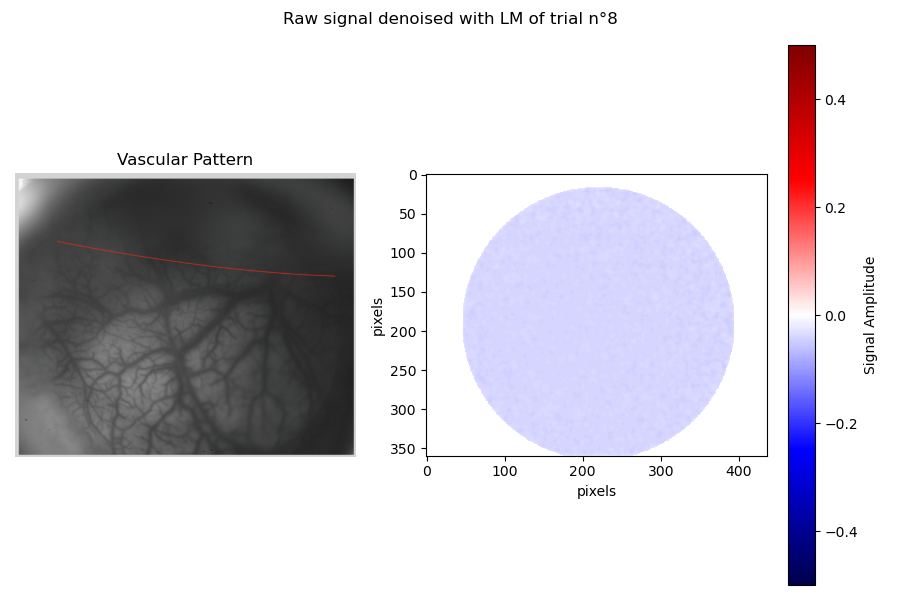

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,6), width_ratios=[0.80,1], tight_layout=True)
fig.suptitle('Raw signal denoised with LM of trial n°8')

vasculature = ax1.imshow(Vasc_pattern, cmap='gray', aspect='equal')

vsd_signal = ax2.imshow(Trial_denoised_smoothed[0], cmap='seismic', aspect='equal', vmin=-.5, vmax=.5)

cbar = fig.colorbar(vsd_signal, ax=ax2, label='Signal Amplitude')

ax1.set_title('Vascular Pattern')
ax1.axis('off')

ax2.set_xlabel('pixels')
ax2.set_ylabel('pixels')

def update(frame):
    vsd_signal.set_array(Trial_denoised_smoothed[frame])
    ax2.set_title('frame n°'+str(frame))
    return [vsd_signal]

ani = anim.FuncAnimation(fig,func=update,frames=range(Nt),interval=100,repeat=False)
plt.show()

## 4 : Denoising of the Raw data with LM